<a href="https://colab.research.google.com/github/Seancode4/dali_data/blob/main/barnacle_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Detectron2

I used Detectron2, a tool for image segmentation and detection based on Mask R-CNN. To do this, I annotated a dataset composed of given images 1 and 2 using Roboflow. I split each image into 36 sub images, creating a dataset of 72. I then used horizontal and vertical flips and saturation and exposure modifications to augment the dataset to 172 images.

The setup, training, and initial evaluations of the model in this notebook are based on the Detectron2 tutorial, which lays out how to use a custom dataset to train a model. I added hyperparameter optimization with optuna and then used the model to detect barnacles in the unseen image.  

Tutorial: https://detectron2.readthedocs.io/en/latest/tutorials/getting_started.html

To run this code, download barnacle_resized.zip from the demo folder and upload it below. This contains the augmented dataset of images from provided image 1 and 2 annotated in the COCO dataset.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving barnacle_resized.zip to barnacle_resized.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("barnacle_resized.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

os.listdir("data/barnacle_resized")

['README.dataset.txt',
 'annotations',
 'test',
 'README.roboflow.txt',
 '.DS_Store',
 'train',
 'valid',
 'unseen']

### Notebook Setup
Sets up notebook to work with Detectron2 based on tutorial. The notebook should be run on the T4 GPU.

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 16.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 15837 (delta 29), reused 12 (delta 12), pack-reused 15773 (from 3)
Receiving objects: 100% (15837/15837), 6.40 MiB | 20.42 MiB/s, done.
Resolving deltas: 100% (11531/11531), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your 

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Registers training (150 images), validation (15 images), and test (7 images) datasets using COCO JSON annotation format.

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {},"data/barnacle_resized/annotations/instances_train.json", "data/barnacle_resized/train")
register_coco_instances("valid", {},"data/barnacle_resized/annotations/instances_valid.json", "data/barnacle_resized/valid")
register_coco_instances("test", {},"data/barnacle_resized/annotations/instances_test.json", "data/barnacle_resized/test")

Displays random image with labels.

[01/20 04:17:41 d2.data.datasets.coco]: Loaded 150 images in COCO format from data/barnacle_resized/annotations/instances_train.json


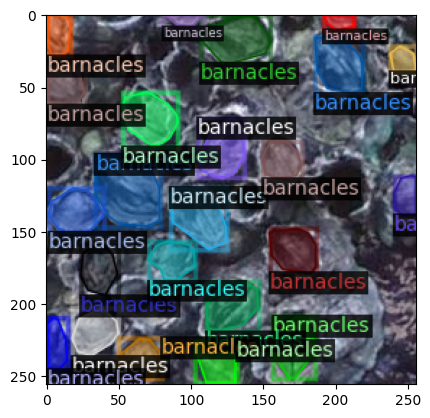

In [ ]:
from detectron2.data import DatasetCatalog
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("train")
nuts_metadata = MetadataCatalog.get('train')

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=nuts_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

### Training

Uses the training images from the barnacle dataset to finetune a model pretrained on the COCO dataset. Uses default parameters for the model.

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# defaults
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/20 04:23:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/20 04:23:45 d2.engine.train_loop]: Starting training from iteration 0
[01/20 04:23:53 d2.utils.events]:  eta: 0:01:49  iter: 19  total_loss: 3.071  loss_cls: 0.7319  loss_box_reg: 0.6437  loss_mask: 0.69  loss_rpn_cls: 0.8208  loss_rpn_loc: 0.1607    time: 0.3911  last_time: 0.3190  data_time: 0.0251  last_data_time: 0.0046   lr: 1.6068e-05  max_mem: 1942M
[01/20 04:24:00 d2.utils.events]:  eta: 0:01:37  iter: 39  total_loss: 2.393  loss_cls: 0.6495  loss_box_reg: 0.7204  loss_mask: 0.6693  loss_rpn_cls: 0.191  loss_rpn_loc: 0.1378    time: 0.3775  last_time: 0.3713  data_time: 0.0068  last_data_time: 0.0051   lr: 3.2718e-05  max_mem: 1942M
[01/20 04:24:08 d2.utils.events]:  eta: 0:01:31  iter: 59  total_loss: 2.144  loss_cls: 0.5516  loss_box_reg: 0.7324  loss_mask: 0.6273  loss_rpn_cls: 0.1146  loss_rpn_loc: 0.1054    time: 0.3842  last_time: 0.4267  data_time: 0.0139  last_data_time: 0.0115   lr: 4.9367e-05  max_mem: 1942M
[01/20 04:24:16 d2.utils.events]:  eta: 0:01:24  iter: 7

In [ ]:
# saves model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# sets required confidence score to 70%
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[01/20 04:25:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

Uses the model to generate predictions on random images from the validation dataset.

[01/20 04:25:47 d2.data.datasets.coco]: Loaded 15 images in COCO format from data/barnacle_resized/annotations/instances_valid.json


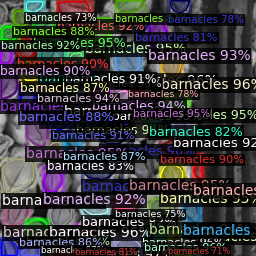

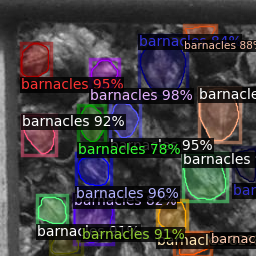

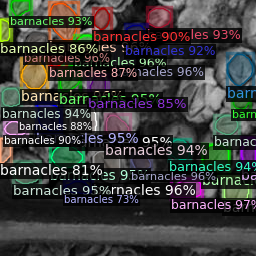

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("valid")
nuts_metadata = MetadataCatalog.get("valid")


for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=nuts_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

To evaluate the model, we get the Average Precision score on the validation datset. For a minimum mask overlap of 50%, the model has a 83.8% average precision. The evaluation also has scores for the average precision at different IoU thresholds and for different size objects. However, because the goal of this program is not to generate exact masks but rather to count the number of barnacles, we use this more flexible threshold.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("valid", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator)["bbox"]["AP50"])

[01/20 04:25:52 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[01/20 04:25:52 d2.data.datasets.coco]: Loaded 15 images in COCO format from data/barnacle_resized/annotations/instances_valid.json
[01/20 04:25:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 04:25:52 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/20 04:25:52 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[01/20 04:25:52 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/20 04:25:52 d2.evaluation.evaluator]: Start inference on 15 batches
[01/20 04:25:54 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0024 s/iter. Inference: 0.0891 s/iter. Eval: 0.0033 s/iter. Total: 0.0948 s/iter. ETA=0:00:00
[01/20 04:25:54 d2.evaluation.evaluator]: 

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

%pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


### Hyperparameter Tuning
Next, I use optuna to hyperparameter tuning. I tune the base learning rate and confidence threshold, optimizing for the highest AP50 score.

In [ ]:
from google.colab import files
best_model = None
current_model = None

def objective(trial):
  global current_model
  print(trial.number)
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.DATASETS.TRAIN = ("train",)
  cfg.DATASETS.TEST = ()
  cfg.DATALOADER.NUM_WORKERS = 2
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

  cfg.SOLVER.IMS_PER_BATCH = 2

  # default 0.00025
  cfg.SOLVER.BASE_LR = trial.suggest_float("base_lr", 0.00020, 0.00050)

  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
  cfg.SOLVER.MAX_ITER = 300
  cfg.SOLVER.STEPS = []
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

  trainer = DefaultTrainer(cfg)
  trainer.resume_or_load(resume=False)
  trainer.train()

  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = trial.suggest_float("confidence_thresh",0.2, 0.7)
  predictor = DefaultPredictor(cfg)
  current_model = (predictor, cfg)

  evaluator = COCOEvaluator("valid", output_dir="./output")
  val_loader = build_detection_test_loader(cfg, "valid")
  results = inference_on_dataset(predictor.model, val_loader, evaluator)
  return results["bbox"]["AP50"]

def save_best(study, trial):
  global best_model, current_model
  if study.best_trial == trial:
    best_model = current_model


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3, callbacks=[save_best])

[I 2025-01-20 04:26:43,894] A new study created in memory with name: no-name-003256e6-0fd0-4bf1-b62d-d07bb22156f5


0
[01/20 04:26:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (r

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/20 04:26:46 d2.engine.train_loop]: Starting training from iteration 0
[01/20 04:26:53 d2.utils.events]:  eta: 0:01:42  iter: 19  total_loss: 2.892  loss_cls: 0.6699  loss_box_reg: 0.6575  loss_mask: 0.6904  loss_rpn_cls: 0.6958  loss_rpn_loc: 0.1586    time: 0.3645  last_time: 0.3701  data_time: 0.0225  last_data_time: 0.0046   lr: 2.6542e-05  max_mem: 2451M
[01/20 04:27:02 d2.utils.events]:  eta: 0:01:37  iter: 39  total_loss: 2.241  loss_cls: 0.59  loss_box_reg: 0.7155  loss_mask: 0.6581  loss_rpn_cls: 0.1275  loss_rpn_loc: 0.1264    time: 0.3895  last_time: 0.4163  data_time: 0.0143  last_data_time: 0.0249   lr: 5.4047e-05  max_mem: 2451M
[01/20 04:27:10 d2.utils.events]:  eta: 0:01:32  iter: 59  total_loss: 2.113  loss_cls: 0.5132  loss_box_reg: 0.7498  loss_mask: 0.595  loss_rpn_cls: 0.1084  loss_rpn_loc: 0.09779    time: 0.3920  last_time: 0.3937  data_time: 0.0096  last_data_time: 0.0154   lr: 8.1551e-05  max_mem: 2451M
[01/20 04:27:17 d2.utils.events]:  eta: 0:01:25  iter: 

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/20 04:28:49 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[01/20 04:28:49 d2.data.datasets.coco]: Loaded 15 images in COCO format from data/barnacle_resized/annotations/instances_valid.json
[01/20 04:28:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 04:28:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/20 04:28:49 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[01/20 04:28:49 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/20 04:28:49 d2.evaluation.evaluator]: Start inference on 15 batches
[01/20 04:28:50 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0014 s/iter. Inference: 0.0911 s/iter. Eval: 0.0031 s/iter. Total: 0.0956 s/iter. ETA=0:00:00
[01/20 04:28:51 d2.evaluation.evaluator]: 

[I 2025-01-20 04:28:51,681] Trial 0 finished with value: 86.97172117996197 and parameters: {'base_lr': 0.00041297853228120326, 'confidence_thresh': 0.3494290335729595}. Best is trial 0 with value: 86.97172117996197.


1
[01/20 04:28:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (r

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/20 04:28:52 d2.engine.train_loop]: Starting training from iteration 0
[01/20 04:29:00 d2.utils.events]:  eta: 0:01:53  iter: 19  total_loss: 2.938  loss_cls: 0.6546  loss_box_reg: 0.6477  loss_mask: 0.6906  loss_rpn_cls: 0.7693  loss_rpn_loc: 0.1539    time: 0.4010  last_time: 0.3880  data_time: 0.0226  last_data_time: 0.0328   lr: 1.8333e-05  max_mem: 2623M
[01/20 04:29:08 d2.utils.events]:  eta: 0:01:44  iter: 39  total_loss: 2.344  loss_cls: 0.6209  loss_box_reg: 0.7196  loss_mask: 0.6665  loss_rpn_cls: 0.1828  loss_rpn_loc: 0.1283    time: 0.3914  last_time: 0.4302  data_time: 0.0098  last_data_time: 0.0054   lr: 3.733e-05  max_mem: 2623M
[01/20 04:29:16 d2.utils.events]:  eta: 0:01:33  iter: 59  total_loss: 2.18  loss_cls: 0.5643  loss_box_reg: 0.7632  loss_mask: 0.6197  loss_rpn_cls: 0.1153  loss_rpn_loc: 0.1114    time: 0.3901  last_time: 0.3959  data_time: 0.0116  last_data_time: 0.0282   lr: 5.6327e-05  max_mem: 2623M
[01/20 04:29:23 d2.utils.events]:  eta: 0:01:25  iter: 

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/20 04:30:54 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[01/20 04:30:54 d2.data.datasets.coco]: Loaded 15 images in COCO format from data/barnacle_resized/annotations/instances_valid.json
[01/20 04:30:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 04:30:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/20 04:30:54 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[01/20 04:30:54 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/20 04:30:54 d2.evaluation.evaluator]: Start inference on 15 batches
[01/20 04:30:56 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0013 s/iter. Inference: 0.0902 s/iter. Eval: 0.0031 s/iter. Total: 0.0946 s/iter. ETA=0:00:00
[01/20 04:30:56 d2.evaluation.evaluator]: 

[I 2025-01-20 04:30:57,137] Trial 1 finished with value: 87.34223308859235 and parameters: {'base_lr': 0.00028524325092418656, 'confidence_thresh': 0.33819327591452886}. Best is trial 1 with value: 87.34223308859235.


2
[01/20 04:30:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (r

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/20 04:30:58 d2.engine.train_loop]: Starting training from iteration 0
[01/20 04:31:06 d2.utils.events]:  eta: 0:01:50  iter: 19  total_loss: 3.077  loss_cls: 0.72  loss_box_reg: 0.6606  loss_mask: 0.693  loss_rpn_cls: 0.7909  loss_rpn_loc: 0.1593    time: 0.3987  last_time: 0.3826  data_time: 0.0230  last_data_time: 0.0247   lr: 2.1917e-05  max_mem: 2627M
[01/20 04:31:13 d2.utils.events]:  eta: 0:01:40  iter: 39  total_loss: 2.295  loss_cls: 0.6205  loss_box_reg: 0.7328  loss_mask: 0.6648  loss_rpn_cls: 0.1504  loss_rpn_loc: 0.1289    time: 0.3901  last_time: 0.3694  data_time: 0.0081  last_data_time: 0.0056   lr: 4.4629e-05  max_mem: 2627M
[01/20 04:31:22 d2.utils.events]:  eta: 0:01:33  iter: 59  total_loss: 2.134  loss_cls: 0.5375  loss_box_reg: 0.7325  loss_mask: 0.6112  loss_rpn_cls: 0.1012  loss_rpn_loc: 0.105    time: 0.3946  last_time: 0.4090  data_time: 0.0154  last_data_time: 0.0277   lr: 6.7341e-05  max_mem: 2627M
[01/20 04:31:29 d2.utils.events]:  eta: 0:01:26  iter: 79

/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/20 04:32:57 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[01/20 04:32:57 d2.data.datasets.coco]: Loaded 15 images in COCO format from data/barnacle_resized/annotations/instances_valid.json
[01/20 04:32:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 04:32:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/20 04:32:57 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[01/20 04:32:57 d2.data.common]: Serialized dataset takes 0.07 MiB
[01/20 04:32:57 d2.evaluation.evaluator]: Start inference on 15 batches
[01/20 04:32:58 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0013 s/iter. Inference: 0.0890 s/iter. Eval: 0.0027 s/iter. Total: 0.0930 s/iter. ETA=0:00:00
[01/20 04:32:59 d2.evaluation.evaluator]: 

[I 2025-01-20 04:32:59,628] Trial 2 finished with value: 83.64598468237531 and parameters: {'base_lr': 0.00034101944587266086, 'confidence_thresh': 0.6187069939382287}. Best is trial 1 with value: 87.34223308859235.


In [ ]:
print("Best hyperparameters:", study.best_params)
print(study.best_value)

Best hyperparameters: {'base_lr': 0.00028524325092418656, 'confidence_thresh': 0.33819327591452886}
87.34223308859235


### Evaluation
Through tuning, we get a model with an AP50 score of 87.3 using the above parameters. We can now evaluate our tuned model on images it has never seen before using a test dataset. On this dataset, it gets an AP50 of 79.6%. Before tuning, the model would have scored 73.5% on these images.

In [ ]:
predictor_opt = best_model[0]
cfg_opt = best_model[1]

evaluator = COCOEvaluator("test", output_dir="./output")
val_loader = build_detection_test_loader(cfg_opt, "test")
print(inference_on_dataset(predictor_opt.model, val_loader, evaluator)["bbox"]["AP50"])

[01/20 04:34:03 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[01/20 04:34:03 d2.data.datasets.coco]: Loaded 7 images in COCO format from data/barnacle_resized/annotations/instances_test.json
[01/20 04:34:03 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| barnacles  | 287          |
|            |              |
[01/20 04:34:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 04:34:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/20 04:34:03 d2.data.common]: Serializing 7 elements to byte tensors and concatenating them all ...
[01/20 04:34:03 d2.data.common]: Serialized dataset takes 0.06 MiB
[01/20 04:34:03 d2.evaluation.evaluator]: Start inference on 7 batches
[01/20 04:34:04 d

Finally, let's use this model to count the number of barnacles in the unseen image. No subsection of this image was used in any of the train, validate or test datasets. First, let's test the model on one subsection.

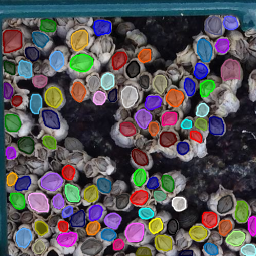

100 barnacles detected


In [ ]:
import glob
from PIL import Image

total_instances = 0
for f in glob.glob("data/barnacle_resized/unseen/*"):
  img_id = f.split("unseen/")[1].split(".jpg")[0]
  im = cv2.imread(f)
  im = cv2.resize(im, (256, 256))
  outputs = predictor_opt(im)
  v = Visualizer(im[:, :, ::-1],
                  scale=1,
                  instance_mode=ColorMode.IMAGE_BW
  )
  instances = v.overlay_instances(
                  boxes=None,
                  masks=outputs["instances"].pred_masks.to("cpu"),
  )


  output = Image.fromarray(instances.get_image()[:, :, ::-1])
  output.save("data/" + img_id + "_predict.jpg")

  total_instances += len(outputs["instances"])
  if "3_1" in img_id:
    cv2_imshow(instances.get_image()[:, :, ::-1])
    print(len(outputs["instances"]), "barnacles detected")


And finally, recombine all subsections for the final count.

851 barnacles detected


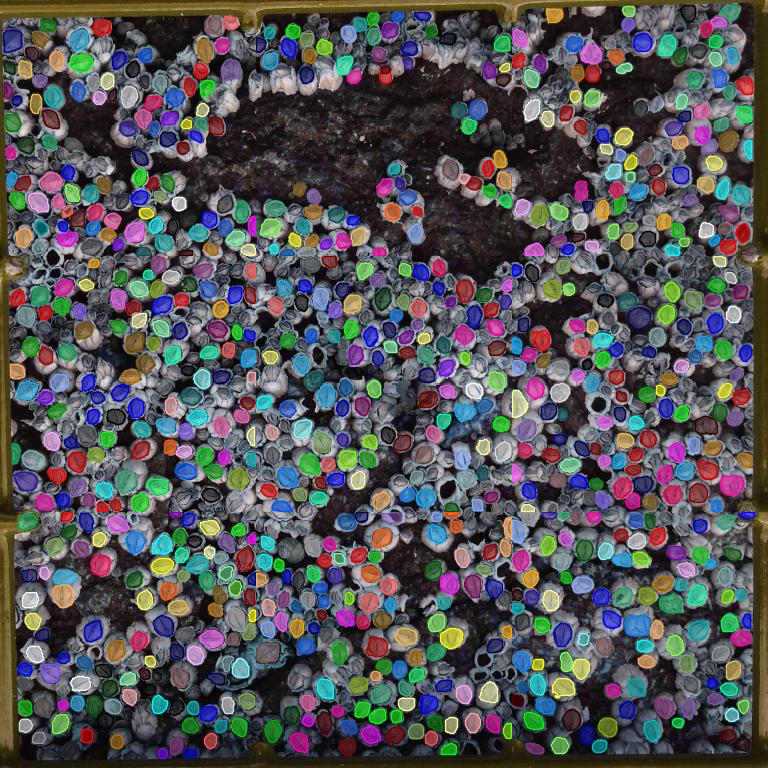

In [ ]:
full_image = Image.new('RGB', (256*3, 256*3))
for f in glob.glob("data/*_predict.jpg"):
  section_id = int(f.split("data/img_3_")[1].split("_predict.jpg")[0])
  col = (section_id-1)%3
  row = (section_id-1)//3

  im = Image.open(f)
  full_image.paste(im, (col*256,row*256))

print(total_instances, "barnacles detected")
full_image

We find 851 out of the 1271 barnacles! The model finds a lot of the barnacles, but struggles with some of the smaller barnacles or barnacles that are angled away from the top view. This could be corrected with further expansion of the training dataset beyond the provided two images but gets a lot of the barnacles detected!